In [93]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', None)


## В этом ноутбуке будем отбирать самые важные фичи из тех что нам удалось собрать и посмотрим на то есть ли полиномиальные или нелинейные зависимости между фичей и таргетом

### Подготовка и нормировка данных

In [70]:
X_train = pd.read_csv('../data/ohe-no-norm/X_train.csv')
X_test = pd.read_csv('../data/ohe-no-norm/X_test.csv')
y_train = pd.read_csv('../data/ohe-no-norm/y_train.csv')
y_test = pd.read_csv('../data/ohe-no-norm/y_test.csv')
test = pd.read_csv('../data/ohe-no-norm/X_train.csv')

### Посмотрим на ковариации и pairplot

In [85]:
corrs = X_train.apply(lambda x: x.corr(y_train.target))
order = corrs.abs().sort_values(ascending = False)
corrs_ordered = corrs[order.index]

train = X_train.copy()
train['target'] = y_train.to_numpy()

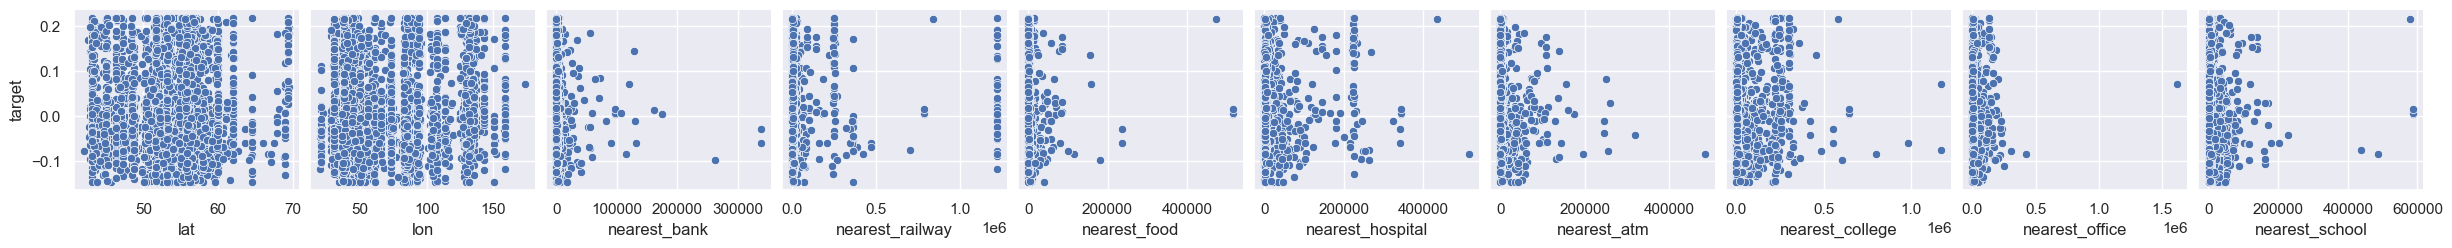

In [86]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[:10])


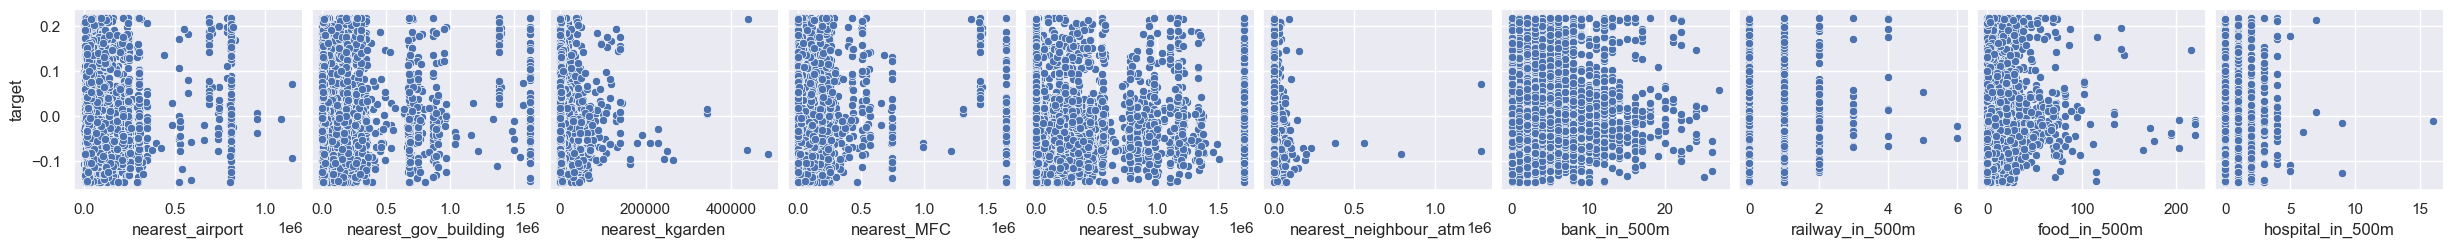

In [87]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[10:20])

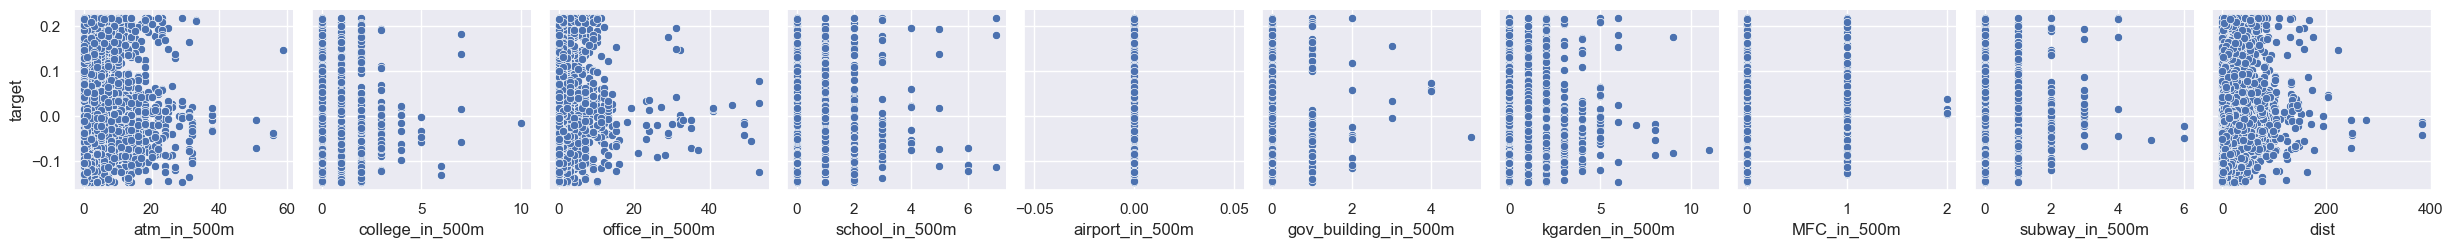

In [88]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[20:30])

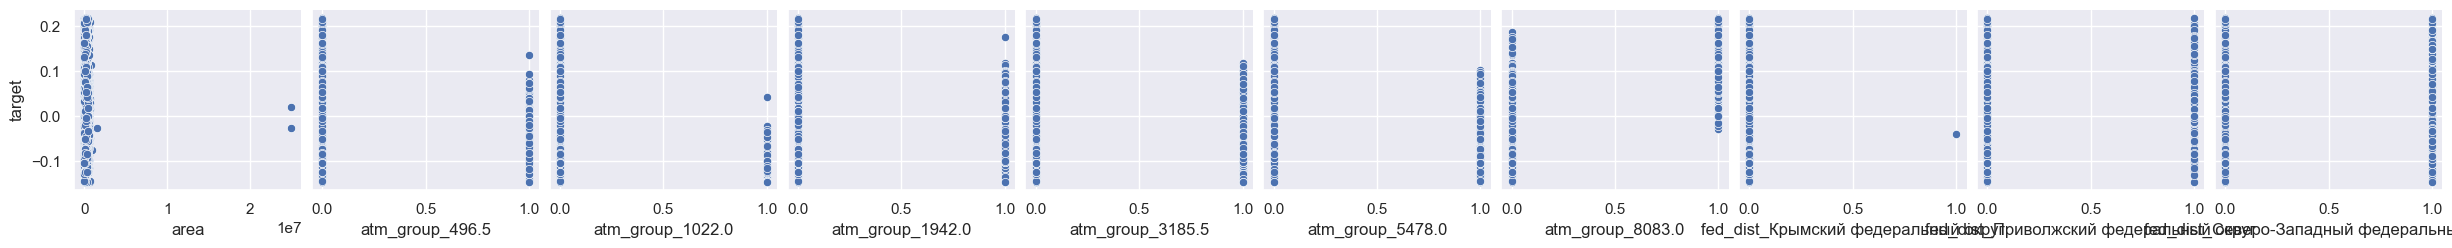

In [89]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[30:40])

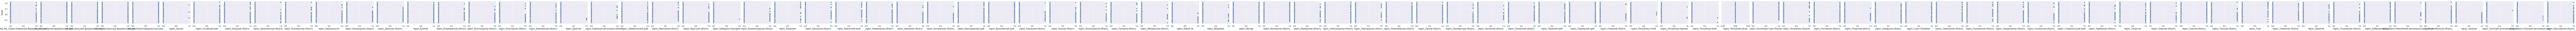

In [90]:
pp = sns.pairplot(data=train,
                  y_vars=['target'],
                  x_vars=list(X_train)[40:])

In [94]:
corrs_ordered

atm_group_8083.0                                   0.788394
atm_group_5478.0                                  -0.353957
atm_group_496.5                                   -0.186590
atm_group_3185.5                                  -0.170246
atm_group_1022.0                                  -0.154120
region_Москва                                      0.151427
fed_dist_Приволжский федеральный округ            -0.140851
lon                                                0.125322
region_Татарстан                                  -0.113535
region_Тыва                                        0.112146
bank_in_500m                                       0.101204
region_Приморский край                             0.099004
region_Красноярский край                           0.091773
dist                                               0.086000
nearest_subway                                     0.077955
subway_in_500m                                     0.076722
region_Хабаровский край                 

In [96]:
selected_columns = corrs_ordered[corrs_ordered.abs()>0.01].index.to_list()

#### Особо нелинейных зависимостей в таргетом (или каких-то зависимостей) на графике не видно. Для использования на других моделях будем использовать фичи с корреляцией больше 0.01 (почему? Потому что я так чувствую) и удалим 500м так как оно сильно коррелирует с 250м

In [ ]:
X_train[selected_columns]

,atms_250m,atm_group_8083.0,banks_250m,hospitals_250m,apartments_min_dist,gov_building_250m,college_250m,college_min_dist,atm_group_3185.5,railway_min_dist,bus_stop_min_dist,MFC_250m,subway_250m,office_min_dist,banks_min_dist,kgarden_min_dist,atm_group_1942.0,school_250m,railway_250m,kgarden_250m
0,-0.658183,-0.445467,-0.724842,1.230279,0.395139,-0.060125,-0.155171,1.724306,-0.318159,-0.202848,-0.055831,-0.135609,-0.211546,2.732198,0.977653,2.491740,-0.473610,-0.232191,-0.271419,-0.259480
1,0.689434,-0.445467,-0.724842,1.230279,0.395139,-0.060125,-0.155171,1.163737,-0.318159,-0.522124,-0.539720,-0.135609,-0.211546,-0.276655,-0.151341,-0.507439,-0.473610,-0.232191,-0.271419,-0.259480
2,-0.321279,2.244836,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,0.172300,-0.318159,-0.818787,0.100271,-0.135609,-0.211546,-0.291846,-0.178851,-0.738886,-0.473610,-0.232191,-0.271419,-0.259480
3,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,-0.056889,-0.318159,2.675394,2.868022,-0.135609,-0.211546,-0.577167,-0.234711,-0.478112,-0.473610,-0.232191,-0.271419,-0.259480
4,-0.658183,2.244836,-0.252937,-0.417354,-2.685868,-0.060125,-0.155171,0.007010,-0.318159,0.381728,-0.493772,-0.135609,-0.211546,-0.484782,-0.278678,-0.738331,-0.473610,-0.232191,-0.271419,-0.259480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,1.720357,-0.318159,1.332596,-0.541233,-0.135609,-0.211546,2.213351,5.345353,0.308552,2.111443,-0.232191,-0.271419,-0.259480
4761,-0.658183,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,1.724306,3.143087,-0.203760,0.197211,-0.135609,-0.211546,0.118353,-0.246234,-0.777585,-0.473610,3.161642,-0.271419,2.544201
4762,0.015626,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,-0.296367,3.143087,0.314585,-0.537823,-0.135609,-0.211546,-0.354085,-0.133038,-0.321894,-0.473610,-0.232191,-0.271419,-0.259480
4763,-0.321279,-0.445467,-0.724842,-0.417354,0.395139,-0.060125,-0.155171,0.703099,-0.318159,-0.249444,-0.544033,-0.135609,-0.211546,-0.389833,-0.107843,1.334198,-0.473610,-0.232191,-0.271419,-0.259480


In [ ]:
corr = X_train[selected_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [62]:
X_train[selected_columns].to_csv('../X_train_transformed_reduced.csv')
y_train.to_csv('../y_train_transformed_reduced.csv')
X_test[selected_columns].to_csv('../X_test_transformed_reduced.csv')
y_test.to_csv('../y_test_transformed_reduced.csv')
test[selected_columns].to_csv('../test_transformed_reduced.csv')

In [63]:
X_train.to_csv('../X_train_transformed.csv')
y_train.to_csv('../y_train_transformed.csv')
X_test.to_csv('../X_test_transformed.csv')
y_test.to_csv('../y_test_transformed.csv')
test.to_csv('../test_transformed.csv')